In [2]:
import time
import requests
import io
import hashlib
import os
from PIL import Image
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

Found: 0 search results. Extracting links from 0:0
Found: 0 search results. Extracting links from 0:0
Found: 0 search results. Extracting links from 0:0
Found: 48 search results. Extracting links from 0:48
Message: element not interactable
  (Session info: chrome=121.0.6167.162)
Stacktrace:
	GetHandleVerifier [0x00007FF746095E42+3538674]
	(No symbol) [0x00007FF745CB4C02]
	(No symbol) [0x00007FF745B6599D]
	(No symbol) [0x00007FF745BAD406]
	(No symbol) [0x00007FF745BA1950]
	(No symbol) [0x00007FF745BCF0AA]
	(No symbol) [0x00007FF745BA124A]
	(No symbol) [0x00007FF745BCF2C0]
	(No symbol) [0x00007FF745BEBDE3]
	(No symbol) [0x00007FF745BCEE53]
	(No symbol) [0x00007FF745B9F514]
	(No symbol) [0x00007FF745BA0631]
	GetHandleVerifier [0x00007FF7460C6CAD+3738973]
	GetHandleVerifier [0x00007FF74611C506+4089270]
	GetHandleVerifier [0x00007FF746114823+4057299]
	GetHandleVerifier [0x00007FF745DE5C49+720121]
	(No symbol) [0x00007FF745CC126F]
	(No symbol) [0x00007FF745CBC304]
	(No symbol) [0x00007FF745C
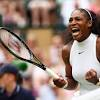

In [3]:


def fetch_image_urls_util(url, driver_path):
    images = []
    service = Service(executable_path=driver_path)
    with webdriver.Chrome(service=service) as wd:
        try:
            wd.get(url)
        except:
            return []

        thumbnail_results = wd.find_elements(By.CSS_SELECTOR, "img[class ='irc_mi']")
        for img in thumbnail_results:
            if img.get_attribute('src') and 'http' in img.get_attribute('src'):
                images.append(img.get_attribute('src'))
    return images

def fetch_image_urls(query:str, max_links_to_fetch:int, wd, sleep_between_interactions:int=1, driver_path=None, target_path=None, search_term=None):
    target_folder = os.path.join(target_path, '_'.join(search_term.lower().split(' ')))
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    

    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    d = {}
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)
        thumbnail_results = wd.find_elements(By.CSS_SELECTOR, "img.Q4LuWd")
        number_results = len(thumbnail_results)

        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")

        for img in thumbnail_results[results_start:number_results]:
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception as e:
                print(e)
                continue

            actual_images = wd.find_elements(By.CSS_SELECTOR, "img.n3VNCb")
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)
            if image_count >= max_links_to_fetch:
                break

        results_start = len(thumbnail_results)
    return image_urls

def persist_image(folder_path:str, url:str):
    try:
        image_content = requests.get(url).content
    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")
        return

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path, hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

def search_and_download(search_term:str, driver_path:str, target_path='./datasets', number_images=50):
    target_folder = os.path.join(target_path, '_'.join(search_term.lower().split(' ')))
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    service = Service(executable_path=driver_path)
    with webdriver.Chrome(service=service) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5, driver_path=driver_path, target_path=target_path, search_term=search_term)
    try:
        for elem in res:
            persist_image(target_folder, elem)
    except Exception as e:
        print(e)

# Example usage
query = ["Serena Williams"]
for q in query:
    search_and_download(q, "./chromedriver.exe")
